In [1]:
#!pip install tensorflow_hub
#!pip install transformers
#!pip install --upgrade tensorflow-hub
from transformers import BertTokenizer, BertModel
import tensorflow_hub as hub

# 加载模型
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)

# 加载预训练的BERT模型和分词器
#model_name = 'neuralmind/bert-base-portuguese-cased'
#tokenizer = BertTokenizer.from_pretrained(model_name)
#model = BertModel.from_pretrained(model_name)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [156]:

#folder_path = "C:/Users/25031/Desktop/新建文件夹/dataset_pt2/_PUBLICO/A_a_grecia_publico/SBERT/"
import os
import torch
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=10'
from nltk.corpus import stopwords
import gc
Vec = []
count = 0
CON = []


for count in range(0,67):
    
    # READ article file
    article_path = "C:/Users/25031/Desktop/新建文件夹/dataset_pt2/_PUBLICO/A_25_de_abril_publico/doc/" + str(count) + ".txt"
    file = open(article_path, 'r', encoding='utf-8')
    content = file.read()
    content = content.replace("\n", " ")
    CON.append(content)
    file.close()
    count = count + 1
    
    
# process by SBERT model
outputs = model(CON)



In [157]:
import numpy
print(len(outputs))
outputs = numpy.array(outputs)
print(type(outputs))
print(outputs.shape)
print(outputs)

67
<class 'numpy.ndarray'>
(67, 512)
[[-0.05103007 -0.0354083  -0.04400484 ...  0.06518175 -0.04727732
  -0.06521145]
 [ 0.02266826  0.01368557 -0.02627646 ...  0.06467165 -0.00466325
  -0.0646777 ]
 [-0.04227672  0.01859396 -0.02096764 ...  0.06144354 -0.05205688
  -0.06155482]
 ...
 [-0.01161882  0.01199497 -0.05013431 ...  0.0577615  -0.01380557
  -0.06641843]
 [-0.03939731 -0.00056487 -0.00268506 ...  0.0558146  -0.04791026
  -0.05581476]
 [-0.05040838  0.03028385 -0.02723645 ...  0.05788875 -0.04944053
  -0.05788876]]


In [196]:
# Extract data from TLS DATASET
import os
folder_path = "C:/Users/25031/Desktop/新建文件夹/dataset_pt2/_PUBLICO/A_25_de_abril_publico/input_docs"
import os

dct = []    # 用于存储文件名的列表

# 遍历当前目录的所有子目录
for subdir in os.listdir(folder_path):
    subdir_path = os.path.join(folder_path, subdir)
    # 如果是文件夹，则进一步遍历其下的文件
    if os.path.isdir(subdir_path):
        for file_name in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file_name)
            # 确保是文件而不是文件夹
            if os.path.isfile(file_path):
                # 打开文件并读取内容
                with open(file_path, 'r', encoding='utf-8') as file:
                    dct.append(file_name[0:10])

print(len(dct))

67


In [197]:
from datetime import datetime, timedelta
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
similarity_matrix = cosine_similarity(outputs)
distance_matrix = 1 - similarity_matrix
np.fill_diagonal(distance_matrix, 0)

# 设置你想要的距离值
large_distance = 100

for i in range(len(dct)-1):
    date_str1 = dct[i]
    date_str2 = dct[i+1]
    time1 = datetime.strptime(date_str1, "%Y-%m-%d")
    time2 = datetime.strptime(date_str2, "%Y-%m-%d")
    time_difference = abs(time2 - time1)   
    
    # 在距离矩阵中为这两篇文章设置距离
    if time_difference > timedelta(days=1) :
        distance_matrix[i][i+1] = large_distance
        distance_matrix[i+1][i] = large_distance



In [198]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(similarity_matrix)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(data_scaled)


In [199]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score


median_value = np.median(reduced_embeddings)
mean_value = np.mean(reduced_embeddings)
preferences = np.linspace(median_value, mean_value, 10)
print(preferences)

best_preference = None
best_score = -1

for preference in preferences:
    clustering = AffinityPropagation(preference=preference).fit(outputs)
    labels = clustering.labels_
    n_clusters = len(set(labels))
    if 1 < n_clusters < len(outputs):
        score = silhouette_score(outputs, labels)

        if score > best_score:
            best_score = score
            best_preference = preference
            
        print(f"preference : {preference} with silhouette score: {score}")
    
print(f"Best preference value: {best_preference} with silhouette score: {best_score}")


[-9.97477770e-01 -8.86646902e-01 -7.75816034e-01 -6.64985166e-01
 -5.54154298e-01 -4.43323430e-01 -3.32492561e-01 -2.21661693e-01
 -1.10830825e-01  4.27018350e-08]
preference : -0.9974777698516846 with silhouette score: 0.07315786927938461
preference : -0.8866469017901824 with silhouette score: 0.022098440676927567
preference : -0.7758160337286802 with silhouette score: 0.022098440676927567
preference : -0.6649851656671781 with silhouette score: 0.022098440676927567
preference : -0.5541542976056759 with silhouette score: 0.03314675763249397
preference : -0.4433234295441737 with silhouette score: 0.05255741626024246
preference : -0.3324925614826716 with silhouette score: 0.047069910913705826
preference : -0.22166169342116948 with silhouette score: 0.0420694574713707
preference : -0.11083082535966726 with silhouette score: 0.02985074184834957
Best preference value: -0.9974777698516846 with silhouette score: 0.07315786927938461


C:\Users\25031\anaconda3\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [200]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation().fit(similarity_matrix)
clusters = clustering.labels_
cluster_centers_indices = clustering.cluster_centers_indices_


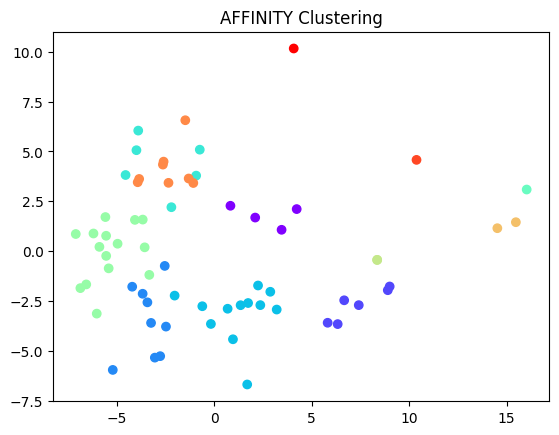

In [201]:
import matplotlib.pyplot as plt

reduced_cluster_centers = pca.transform(similarity_matrix[cluster_centers_indices])

# 绘制散点图
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='rainbow')
#plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], s=5, label='Cluster Center')
plt.title('AFFINITY Clustering')
plt.show()


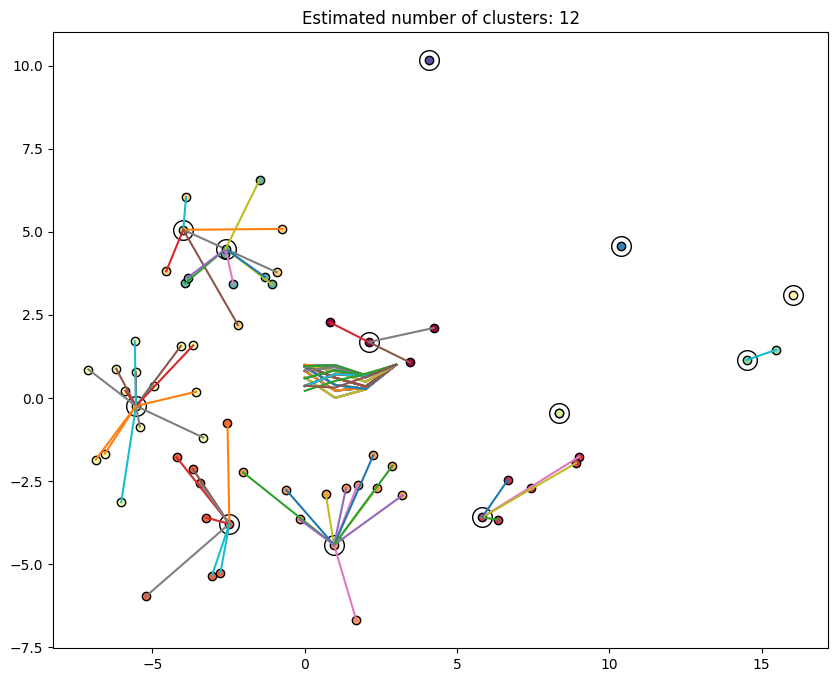

In [202]:

n_clusters_ = len(cluster_centers_indices)
plt.figure(figsize=(10, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters_))
for k, col in zip(range(n_clusters_), colors):
    class_members = clusters == k
    cluster_center = reduced_embeddings[cluster_centers_indices[k]]
    plt.plot(reduced_embeddings[class_members, 0], reduced_embeddings[class_members, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
    plt.scatter(cluster_center[0], cluster_center[1], s=200, c='white', edgecolor='k')
    for x in reduced_embeddings[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


In [203]:
# 查看每个簇的文章数量
import numpy as np
unique_labels = np.unique(clusters)
for label in unique_labels:
    n_articles = sum(clusters == label)
    print(f"Cluster {label}: {n_articles} articles")


Cluster 0: 4 articles
Cluster 1: 6 articles
Cluster 2: 9 articles
Cluster 3: 12 articles
Cluster 4: 6 articles
Cluster 5: 1 articles
Cluster 6: 15 articles
Cluster 7: 2 articles
Cluster 8: 2 articles
Cluster 9: 8 articles
Cluster 10: 1 articles
Cluster 11: 1 articles


In [204]:
clustered_list = {}
for article_id,cluster_id  in enumerate(clusters):
    if cluster_id not in clustered_list:
        clustered_list[cluster_id] = []

    clustered_list[cluster_id].append(article_id)

numC = 1
for n, cluster in clustered_list.items():
    print("Cluster ", n+1)
    print(cluster) 
    numC = numC+1
    

Cluster  1
[0, 17, 37, 55]
Cluster  3
[1, 5, 18, 22, 23, 30, 34, 46, 59]
Cluster  7
[2, 10, 13, 14, 15, 16, 25, 26, 31, 36, 50, 52, 53, 58, 62]
Cluster  2
[3, 4, 6, 33, 43, 54]
Cluster  4
[7, 21, 24, 28, 32, 35, 42, 45, 47, 49, 51, 60]
Cluster  5
[8, 9, 12, 20, 29, 39]
Cluster  9
[11, 61]
Cluster  10
[19, 27, 38, 40, 41, 44, 63, 66]
Cluster  6
[48]
Cluster  8
[56, 57]
Cluster  11
[64]
Cluster  12
[65]


    cluster  num
0         0    4
1         2    9
2         6   15
3         1    6
4         3   12
5         4    6
6         8    2
7         9    8
8         5    1
9         7    2
10       10    1
11       11    1


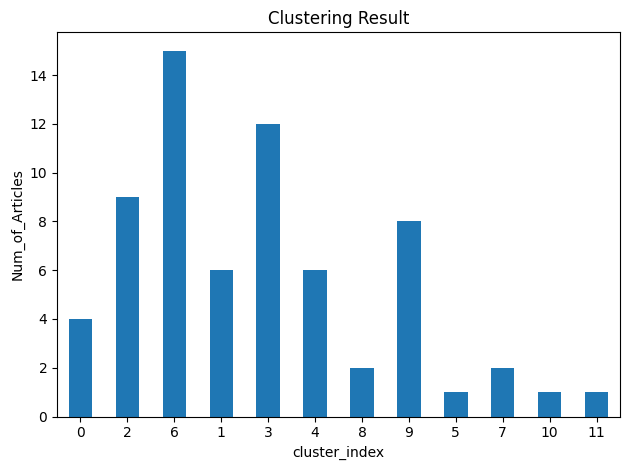

In [205]:
# 统计聚类情况
cluster_num = []
cluster_index = []
for n,cluster in clustered_list.items():
    size = len(cluster)            
    cluster_index.append(n)
    cluster_num.append(size)
    
import pandas as pd

data = {
    'cluster': cluster_index,
    'num': cluster_num
}

df = pd.DataFrame(data)

print(df)    

df.to_csv('C:/Users/25031/Desktop/新建文件夹/dataset_pt2/_PUBLICO/A_wuhan_publico/SB+AFF.csv', index=False)

import pandas as pd
import matplotlib.pyplot as plt


ax = df.plot(kind='bar', x='cluster', y='num', legend=False)


# 添加标题和标签
plt.title('Clustering Result')
plt.xlabel('cluster_index')
plt.ylabel('Num_of_Articles')
plt.xticks(rotation=0)  # 设置x轴标签的旋转角度

# 显示图形
plt.tight_layout()
plt.show()


In [206]:
import os
import re

folder_path = 'C:/Users/25031/Desktop/新建文件夹/dataset_pt2/_PUBLICO/A_wuhan_publico/time/'


# 日期格式
date_pattern = re.compile(r'\d{4}-\d{2}-\d{2}')
# 所有文章的对应日期信息
data_lists = []

count = 0
for count in range(len(outputs)):
    path = folder_path + str(count) + ".txt"
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        data_list = [line.strip() for line in lines if date_pattern.match(line.strip())]
        data_lists.append(data_list)


In [136]:
print(data_lists[0])

['2020-03-16', '2020-03-16', '2020-03-15']


In [137]:
count = 0
for count in range(len(outputs)):
    data_lists[count].append(dct[count])    
    
print(data_lists[0:5])


[['2020-03-16', '2020-03-16', '2020-03-15', '2020-03-16'], ['2020-03-19TMO', '2020-03-19', '2020-03-19'], ['2020-03-19', '2020-03-19', '2020-03-19'], ['2020-03-18', '2020-03-19'], ['2020-03-19', '2020-03-19']]


In [138]:
date_all_cluster = []

for n, cluster in clustered_list.items():
    date_each_cluster = []
    for article_num in cluster:
        for date in data_lists[article_num]:
            date_each_cluster.append(date[0:10])
            
    # cluster的编号对应日期list        
    temp = []
    temp.append(n+1)
    temp.append(date_each_cluster)
    date_all_cluster.append(temp)
    
print(date_all_cluster[0])          

[15, ['2020-03-16', '2020-03-16', '2020-03-15', '2020-03-16', '2020-03-19', '2020-03-19', '2020-03-19', '2020-03-28', '2020-04-13', '2020-04-08', '2020-04-13', '2020-09-04', '2020-11-13', '2020-08-17', '2020-11-13', '2020-12-11', '2020-12-10', '2020-07-27', '2020-12-07', '2020-12-11', '2020-12-22', '2020-12-15', '2020-12-22', '2020-12-23', '2021-03-01', '2021-03-01']]


In [139]:
from collections import Counter
# 存取每个cluster对应的出现最多的日期和次数
set_of_cluster_date = []
for data in date_all_cluster:
    key = data[0]
    value = data[1]
    counter = Counter(value)
    most_common_element, count = counter.most_common(1)[0]
    print("CLUSTER : ", key)
    print(most_common_element)  
    print(count)  
    temp = {"cluster" : key, "date" : most_common_element, "count" : count}
    set_of_cluster_date.append(temp)

CLUSTER :  15
2020-03-16
3
CLUSTER :  4
2021-02-09
4
CLUSTER :  1
2020-03-24
3
CLUSTER :  16
2020-06-28
3
CLUSTER :  5
2020-03-29
3
CLUSTER :  3
2020-03-23
4
CLUSTER :  14
2020-11-16
2
CLUSTER :  7
2020-03-29
2
CLUSTER :  2
2020-03-24
2
CLUSTER :  9
2020-03-27
2
CLUSTER :  22
2021-02-04
4
CLUSTER :  10
2020-06-15
7
CLUSTER :  18
2021-01-27
5
CLUSTER :  12
2020-04-09
2
CLUSTER :  6
2020-05-01
1
CLUSTER :  23
2021-05-28
3
CLUSTER :  11
2020-05-10
3
CLUSTER :  8
2020-05-07
2
CLUSTER :  13
2020-06-26
3
CLUSTER :  20
2020-09-10
3
CLUSTER :  19
2021-01-14
5
CLUSTER :  17
2021-01-22
2
CLUSTER :  21
2021-05-01
1


In [140]:
# 按照频率进行排序
sorted_list = sorted(set_of_cluster_date, key=lambda x: x['count'], reverse=True)

for item in sorted_list:
    print(item)

{'cluster': 10, 'date': '2020-06-15', 'count': 7}
{'cluster': 18, 'date': '2021-01-27', 'count': 5}
{'cluster': 19, 'date': '2021-01-14', 'count': 5}
{'cluster': 4, 'date': '2021-02-09', 'count': 4}
{'cluster': 3, 'date': '2020-03-23', 'count': 4}
{'cluster': 22, 'date': '2021-02-04', 'count': 4}
{'cluster': 15, 'date': '2020-03-16', 'count': 3}
{'cluster': 1, 'date': '2020-03-24', 'count': 3}
{'cluster': 16, 'date': '2020-06-28', 'count': 3}
{'cluster': 5, 'date': '2020-03-29', 'count': 3}
{'cluster': 23, 'date': '2021-05-28', 'count': 3}
{'cluster': 11, 'date': '2020-05-10', 'count': 3}
{'cluster': 13, 'date': '2020-06-26', 'count': 3}
{'cluster': 20, 'date': '2020-09-10', 'count': 3}
{'cluster': 14, 'date': '2020-11-16', 'count': 2}
{'cluster': 7, 'date': '2020-03-29', 'count': 2}
{'cluster': 2, 'date': '2020-03-24', 'count': 2}
{'cluster': 9, 'date': '2020-03-27', 'count': 2}
{'cluster': 12, 'date': '2020-04-09', 'count': 2}
{'cluster': 8, 'date': '2020-05-07', 'count': 2}
{'cluste

In [141]:
# 确认 gold_standard 里面有几个时间
file_path = "C:/Users/25031/Desktop/新建文件夹/dataset_pt/txt/wuhan_publico/timelines/wuhan.txt"
separator = "--------------------------------"
with open(file_path, "r", encoding='utf-8') as file:
    content = file.read()
    
content = content.replace('\n', '')
data = content.split(separator)
pro_data = []
for d in data :
    if d != '':
        pro_data.append(d[0:10])
    
print(len(pro_data))

72


In [142]:
# 对比 gold_standard 和 聚类结果
num_of_tls = len(pro_data)

cluster = sorted_list[0:num_of_tls]

Golden = []
for clus in cluster :
    Golden.append(clus["date"])

print(len(Golden))    
print(num_of_tls) 

#print(Golden)    
#print(pro_data) 

set1 = set(Golden)
set2 = set(pro_data)

# 找出相同的日期
common_elements = set1 & set2

common_num = len(common_elements)

precision = common_num/num_of_tls
recall = common_num/num_of_tls
print("Precision : ", precision)

F1_score = (2*precision*recall)/(precision+recall)
print("F1 SCORE : ", F1_score)


23
72
Precision :  0.1388888888888889
F1 SCORE :  0.1388888888888889
